In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit



In [3]:
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [22]:
def plot_predictions(ser, ser_pred, label):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_pred, color='red', linewidth='4', label=label)
        plt.plot(ser, color='blue',label='original')
        plt.legend()
    plt.show()

# Стационарный ряд

In [30]:
series = female_births['Count']

Это ряд был наиболее близок к стационарному.

Будем прогнозровать как стационарный. Выберем EMA - она должна хорошо справиться, т.к нет ни тредда ни сезонности

In [68]:
idx = int(series.shape[0] * .8)
train = series[:idx]
val = series[idx:]

In [75]:

def ema_prediction(series, alpha, n_pred):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]
    for _ in range(n_pred-1):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return pd.Series(predictions)

In [76]:
def mse_cv_ema(alpha):
    split = TimeSeriesSplit(n_splits=5) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        predictions = ema_prediction(train_split_ts, alpha, len(test_split_ts))
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [82]:
opt = minimize(
    mse_cv_ema, 
    x0=(0.5), 
    method="Nelder-Mead", 
    bounds = [(0, 1)]
)


59.221246370318305------------
59.573855035956036------------
58.89895315037789------------
58.596350693287114------------
58.00807261702486------------
57.37551077977177------------
55.7025138315582------------
53.20170051264374------------
104.8875------------
55.7025138315582------------
50.77073742846343------------
104.8875------------
104.8875------------
51.75137900130751------------
104.8875------------
51.11403632570915------------
52.03267858665212------------
50.87678680715666------------
50.972014792054644------------
50.80036525064546------------
50.813401943423436------------
50.77841276836152------------
50.780866798655------------
50.77259146245776------------
50.7733180225451------------
50.77114076315304------------
50.771441719894526------------
50.770804501924225------------
50.77094719715518------------
50.77073684424621------------
50.7708045019242------------
50.770728546202726------------


Оптимальное значение альфа

In [83]:
opt.x

array([0.05009766])

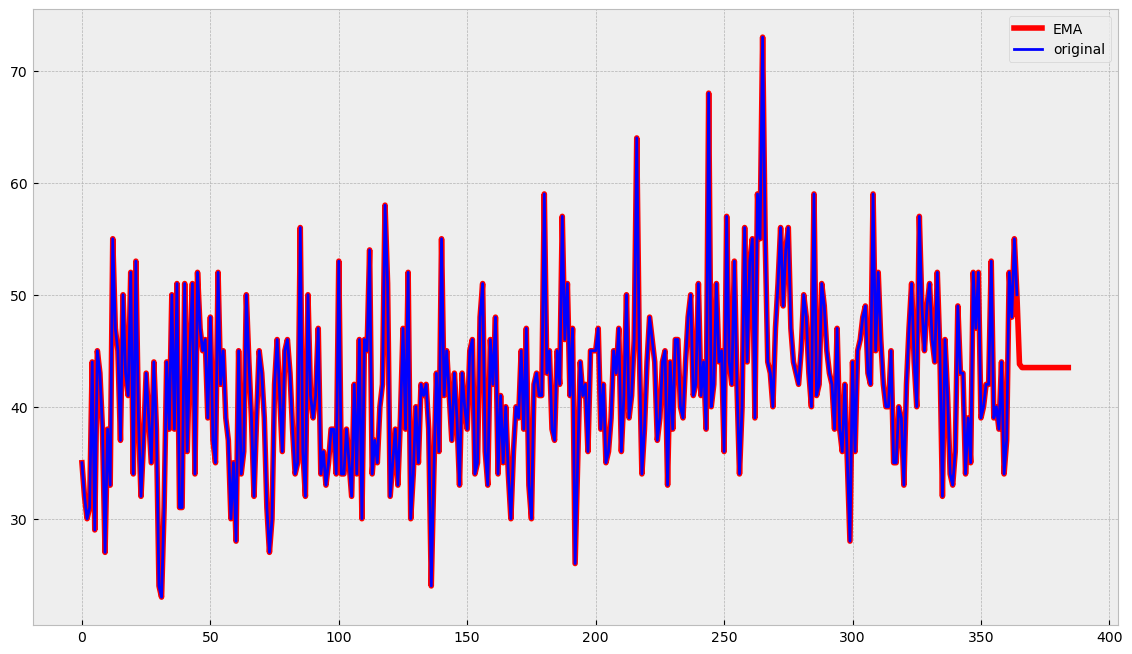

In [85]:
plot_predictions(
    series,
    pd.concat([series,  ema_prediction(series, opt.x[0], 20)], ignore_index=True),
    'EMA'
)


Проверим ошибку на валидационной выборке

In [87]:
np.sqrt(mean_squared_error(ema_prediction(series, opt.x[0], len(val)), val))

6.441594350541524

# Не стационарный ряд


In [88]:
series = dowjones_closing['Close']

Этот ряд имеет тренд, но не имеет сезонности. Воспользуемся DEMA

In [89]:
idx = int(series.shape[0] * .8)
train = series[:idx]
val = series[idx:]

In [91]:
def dema_prediction(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(preds)

In [106]:
def mse_cv_dema(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=5) 
    errors = []
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        predictions = dema_prediction(train_split_ts, alpha, beta, len(test_split_ts))
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [115]:
opt = minimize(
    mse_cv_dema,
    x0=[0.5, 0.5],
    method="Nelder-Mead", 
    bounds=[(0, 1), (0, 1)]
)

10272.413799912543------------
10551.637354749542------------
11409.754804259574------------
9442.645646423965------------
8501.715084430067------------
8263.140429076082------------
7233.900427516307------------
5784.132761151918------------
4208.356846562559------------
3787.5827132078207------------
3255.932503414224------------
2986.9977517040898------------
24704.23421723198------------
25430.64976354096------------
3137.1592571319015------------
2839.358270505669------------
2475.082489242238------------
24254.562754786566------------
2886.155275715246------------
2536.78861531763------------
2058.8034168268737------------
12074.947370601461------------
23993.030582639043------------
2517.5073906366583------------
2426.0720301549------------
7397.570850595822------------
2197.394260490011------------
2350.675614121328------------
2258.1324373727684------------
2048.803755534121------------
2426.0720301549------------
1977.5739717224103------------
2150.1785628805073------------
2

In [116]:
# Оптимальные параметры
opt.x

array([1.        , 0.04786478])

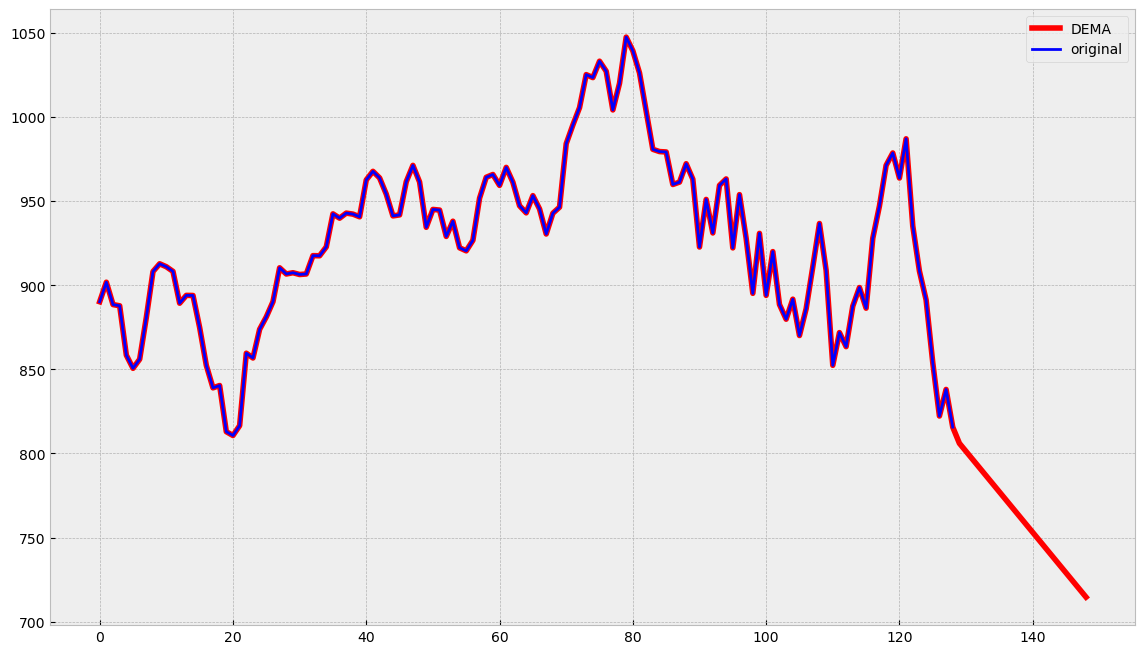

In [118]:
plot_predictions(
    train, 
    pd.concat([train, dema_prediction(train, opt.x[0], opt.x[1], 20)], ignore_index=True), 
    'DEMA'
)

In [117]:
np.sqrt(mean_squared_error(dema_prediction(series, opt.x[0],opt.x[1], len(val)), val))

164.75083986670867